# **과제 제출란**


여기에 학습 성공한 스크린샷을 넣어주세요

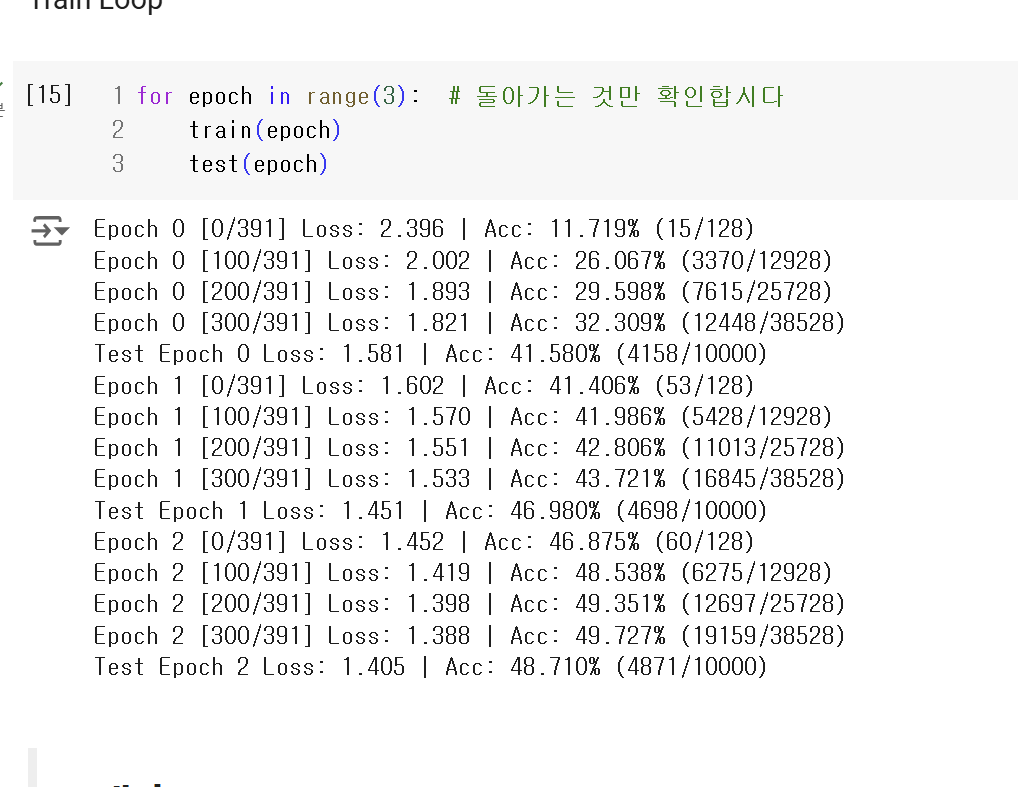


# **Swin Transformer: Hierarchical Vision Transformer using Shifted Windows**

**Advanced ViT 세션 과제**:
* Due: 2024/11/11

**이번 과제에서 저희는**:
* 코드와 함께 세션 때 배운 Swin Transformer에 대해 복습하고,
* 실제 데이터셋을 사용해서 실습까지 진행해 볼 계획입니다.
* **colab**으로 진행하시면 됩니다~

**해야될 일:**
* 내용을 읽고
* 중간중간에 간단한 **TODO**를 채운 후
* 완성한 코드 블록을 하나씩 실행시키면서 진행하시면 됩니다.
  - **Hint**: TODO 위치에 저희가 함께 구현한 함수 이름만 넣으시면 됩니다.

오래 안 걸릴 거라고 생각합니다~

> # **Introduction**

Swin Transformer는 2021년(ICCV) Microsoft에서 발표한 논문으로, 기존 ViT 모델의 2가지 한계점을 해결하기 위해 제안되었습니다.
* **Scale**: NLP분야에서는 단어 하나하나가 같은 크기(scale)로 처리되기 때문에, 모든 단어가 동일한 방식(fixed-scale token)으로 다뤄집니다. 하지만 이미지에서는 다양한 크기의 시각적 요소들이 존재하죠. 예를 들어, 이미지 속 작은 물체와 큰 물체를 같은 방식으로 처리하는 것은 부적절하겠죠? 기존 트랜스포머 모델은 모든 시각적 요소를 동일한 크기로 인식하고 처리하기 때문에 실제 이미지 처리에 적합하지 않다는 문제가 있습니다.

* 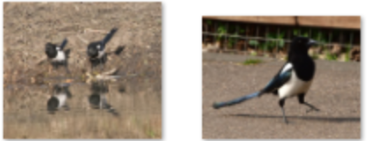

* **High Resolution**: 이미지는 아주 많은 픽셀로 이루어져 있어, 텍스트와 비교하면 훨씬 더 세밀한 정보가 필요합니다. 예를 들어, semantic segmentation 같은 task에서는 각 픽셀마다 의미를 예측해야 하죠. 그런데 트랜스포머 모델은 이미지 크기가 커질수록 계산량이 엄청나게(quadratic) 늘어나기 때문에, 해상도가 높은 이미지를 다루기에는 비효율적이라는 문제가 있습니다.
* 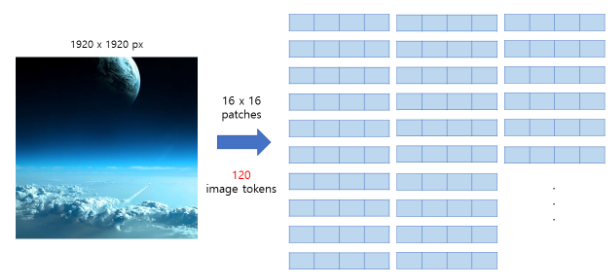

위 문제를 해결하기 위해 제안된 게 바로 Swin Transformer입니다. 가장 큰 특징은 아래 피규어에서 볼 수 있듯이 **Hierachical feature maps**를 가지고 있다는 것.
* 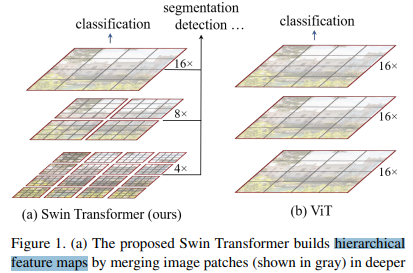
* **Hierachical feature maps**: 작은 이미지 조각(patch)을 시작으로 점점 이웃한 패치들과 합치(merge)면서, 여러 단계로 특징을 쌓아가는 구조. 이를 통해 이미지의 작은 디테일에서부터 큰 구조까지 잘 파악할 수 있다고 합니다.

그리고 또 하나의 특징은 **Linear Complutational Complexity**를 가진다는 것입니다.
* **How?**: 이미지를 작은 창(**Window**) 단위로 나눠서 각 Window 안에서만 patch끼리 셀프 어텐션을 계산하기 때문에, 이미지 크기가 커져도 계산량이 선형적으로 늘어난다고 합니다.

그렇다면 셀프 어텐션 계산이 진행되지 않는 window 경계에 있는 patch들은 어떡할까요? 논문에서는 **Shifted Window**라는 방법을 사용한다고 합니다.
* 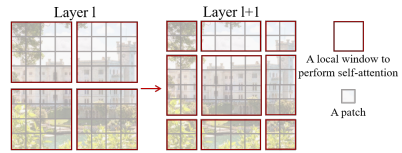

위 피규어에서 볼 수 있듯이, Layer 1에서 왼쪽과 같이 Window를 나눴다면, Layer1+1에서는 오른쪽처럼 Window를 구성합니다. 그럼 Layer 1에서 학습하지 못한 feature를 학습할 수 있겠죠? 아래 조금 더 직관적인 피규어가 있으니 이해에 도움이 되실겁니다.
* 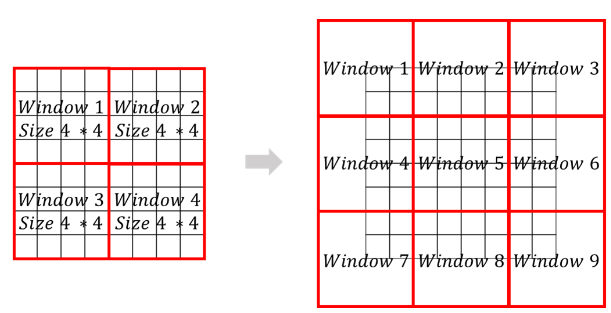

하지만 논문에서는 위와 같은 방법을 사용해도 naive하게 계산을 할 경우 window수가 증가함에따라 추가 연산이 필요하다고 합니다 (위 예시에서는 2.25배) 이를 위해 **cyclic-shift**를 제안하는데 인트로에서는 이쯤하고 모델 설명에서 알아보겠습니다.

> # **Model Architecture**

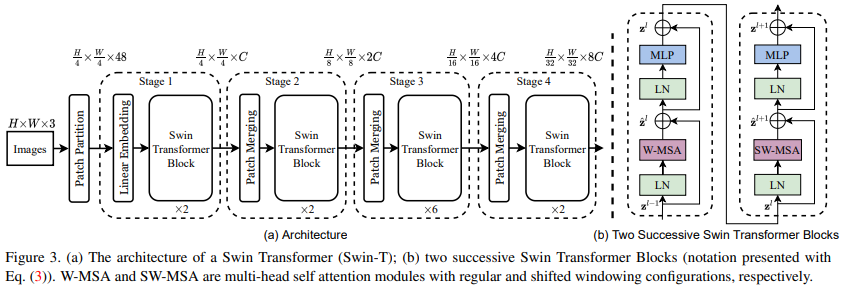

왼쪽에서부터 오른쪽으로 Patch Partition, Linear Embedding, Swin Transformer Block, 그리고 Patch Merging 동작을 수행합니다.
논문에서는 흐름을 4개의 stage로 나눠서 설명합니다.
* **Input**: 입력된 이미지(HxW)를 4x4 크기의 작은 패치로 나눕니다. 이후 임베딩 레이어를 통해 패치를 C 차원으로 변환합니다(C는 하이퍼파라미터).
* **Stage 1**: 입력에 선형 변환을 적용한 후 , Swin Transformer 블록으로 보내 초기 특징을 학습합니다. 이때 각 패치의 차원은 C로 유지됩니다
* **Stage 2**: Patch Merging 동작이 시작됩니다. 인접한 2x2 패치들의 특징을 연결하여 4C 차원으로 만들고, 이를 다시 선형 변환하여 2C 차원으로 줄입니다. 이 과정에서 이미지의 해상도는 절반으로 줄어들어 H/8 x W/8이 됩니다. 이후 Swin Transformer 블록을 통해 더 고차원의 특징을 학습합니다.
* **Stage 3**: Stage2와 동일한 방식으로 해상도를 H/16 x W/16로 줄이고, Swin transformer블록을 통해 학습을 진행합니다.
* **Stage 4**: 마지막 patch merge로 해상도를 H/32 x W/32로 줄이고, Swin transformer블록을 통해 학습을 진행합니다.

Swin Transformer 블록의구조는 피규어 우측에 나와있습니다. 기존 Multi-head self attention(MSA)를 **shifted-window** 기반 MSA (Windows-MS과 Shitfed Windows-MSA)으로 대체한 것이죠. 논문에 의하면 MSA부분을 제외한 다른 component는 기존 Transformer블록과 동일하다고 합니다.
주목할 점은, 처음에는 W-MSA를 통과하고 그다음에는 SW-MSA를 통과하게 된다는 것, 이는 인접한 윈도우 간의 정보를 효과적으로 교환할 수 있게하기 위함입니다.
* **W-MSA**: Window내에서 MSA를 계산하는것
* **SW-MSA**: W-MSA에서 사용한 윈도우의 위치를 이동시켜서 MSA를 계산하는것
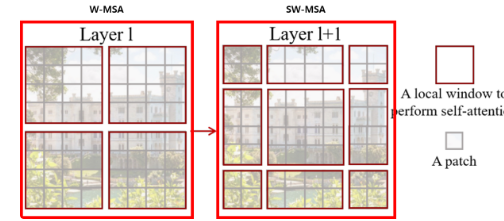

기존 MSA과  shifted-window 기반 MSA의 차이를 수식적으로 표현한다면:

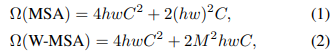

self-attention은 모든 query와 key 쌍에 대해 연산을 수행해야 하므로, 이미지의 해상도가 높아질수록 계산 복잡도가 quadratic하게 증가합니다.

하지만 M(window size)는 h*w(image size)에 비해 훨씬 작기 때문에 이미지가 커지더라도 ViT에 비해 연산량을 줄일 수 있다고 합니다.

설명은 여기까지 하고, 이제 코드와 함께 각 컴포넌트를 살펴봅시다.

> # **구현**

 여기서 부터 코드 블록을 하나씩 실행하면서 과제를 진행하시면 됩니다.

> ## **Patch Partition (+Linear Embedding)**

Input Stage의 구현입니다. 이미지를 패치로 나누고 각 패치를 임베딩하는 동작을 수행합니다. 여기는 코드가 직관적이라서 이해하는데 어려움이 없을 거라고 생각합니다.

In [1]:
import torch
import torch.nn as nn
class PatchEmbed(nn.Module):
    """
      논문에서 제공된 수치를 사용합니다.
         이미지의 크기: 224 * 224 * 3
         patch 크기: 4
         embedding size: 96
    """
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=96):
        super(PatchEmbed, self).__init__()
        # 멤버변수
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size

        # 이미지를 패치로 나누는 동작
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        # 임베딩
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

## **Swin Transformer Block - Preliminaries**

논문의 가장 핵심적인 부분이죠. 하지만 Swin Transformer Block구현을 보기 전에 필요한
- Window Partition
- Shifted Window based MSA (**Window Attention**) + 이때 사용되는 **cyclic-shift**
- 그리고 새로 소개하는 Relative Position Bias까지

각각 개념과 구현을 한 번 간단하게 살펴보고, Swin Transformer Block으로 넘어가겠습니다.

### **Window Partition**
 앞서 Swin Transformer는 입력 이미지를 작은 고정된 크기의 Window로 분할하여 각 Window 내에서만 MSA을 계산하는 방식을 사용한다고 했었죠? 아래 코드는 이미지를 window단위로 나눠주는 역할을 합니다.


In [2]:
def window_partition(x, window_size):
    """
    Args:
        x: 입력 이미지 텐서 (B, H, W, C)
           - B: batch size
           - H: height
           - W: width
           - C: channels
        window_size (int): 윈도우의 크기 (예: 4라면 4x4 윈도우로 나눈 것)

    Returns:
        windows: 윈도우로 나눈 결과 텐서 (num_windows * B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size,W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

그리고 self-attention 계산 후, 최종적으로는 전체 이미지에 대한 정보를 가져야 하므로, 각 윈도우에서 얻은 특징들을 다시 원래의 이미지 형식으로 돌려줘야합니다. 이 과정이 없으면, 윈도우 단위로 나눠진 정보들이 그대로 유지되어 이미지 전체의 맥락을 이해하지 못하겠죠. 아래는 복원 과정을 구현한 것입니다.

In [3]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: 윈도우로 나뉜 텐서 (num_windows * B, window_size, window_size, C)
        window_size: 윈도우의 크기 (예: 4라면 4x4 윈도우로 나눈 것)
        H: 원본 이미지의 높이
        W: 원본 이미지의 너비

    Returns:
        x: 원본 이미지 형태로 복원된 텐서 (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

### **Window Attention - Shifted Window based Self-Attention**
자, Window도 나누었으니, 이제 각 Window내부에서 self-attention 계산이 어떻게 진행 되는지 알아봅시다.

Shifted Window based Self-Attention은 **W-MSA**과 **SW-MSA** 2가지 형태가 있습니다.

- **W-MSA**: Naive하게 Window내부에서 self-attention계산을 하면 됩니다.
- **SW-MSA**: 인트로에서 아래 피규어 잠깐 봤었죠? Window수가 많아지기 때문에 연산량이 증가하는데, 이를 해결하기 위해 **cyclic shift**이라는 방법을 사용합니다. 2 X 2에서 3 X 3개의 window가 된다면 2.25배의 추가적인 연산을 수행해야 되겠죠.

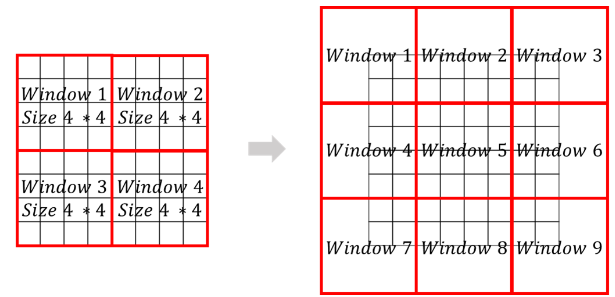

#### **Cyclic Shift**
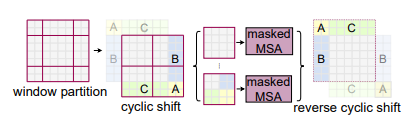

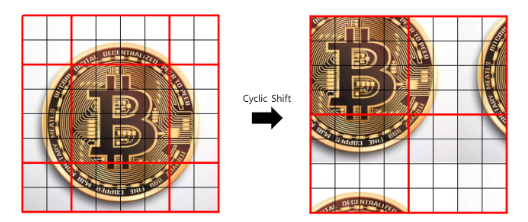

그림만 봐도 어떤 느낌인지 알 수 있겠죠? 왼쪽에 있는 window를 오른쪽 아래로 이동시키는 것입니다. 주의해야 될 점은 Masked MSA를 적용한다는 것. 피규어 속 A,B,C구역은 오른쪽에 위치한 pixel과는 큰 연관성이 없어서 계산할 때 A, B, C 구역에 Mask를 적용합니다.

Cyclic Shift 후 self-attention을 진행하면  W-MSA랑 같은 방식으로 연산을 진행함에 따라 더 효과적으로(batch 단위로) MSA를 계산할 수 있다고 합니다. 물론 연산 진행 후, reverse cyclic shift로 돌려놓아야겠죠.

#### **Relative Position Bias**

*  image.png


Swin Transformer는 ViT와 다르게 position embedding을 입력 단계에서 더하지 않고
self-attention 과정에서 relative position bias(B) 를 추가함으로써 그 역할을 대체하였다고합니다. 이유는...그냥 Relative Position Bias를 쓰니까 성능이 더 좋았다고 합니다. 넘어가죠.


그럼 Window Attention의 코드 구현을 보겠습니다. Cyclic Shift동작과 Attention Mask 생성은 Swin Transformer 블록에서 수행하고, 여기는 단순 window 내 self-attention계산 구현입니다.

In [4]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout=0., attn_drop=0.):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size  # window size (Wh, Ww)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        ################################ Relative Position Bias, 넘어가시죠!ㅎㅎ,,, #################################
        # 자세한 내용이 궁금하시면 세션 슬라이드 혹은 https://www.youtube.com/watch?v=2lZvuU_IIMA&t=1306s
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size -1) * (2 * window_size -1), num_heads)
        )

        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid(
            [coords_h, coords_w], indexing='ij'))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - \
            coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(
            1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size -1
        relative_coords[:, :, 1] += window_size -1
        relative_coords[:, :, 0] *= 2 * window_size -1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        #########################################################################################

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, x, mask=None):
        B_, N, C = x.shape

        ################################ self-attention  #########################################
        qkv = self.qkv(x)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)

        # Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaling
        q = q * self.scale

        # attention score 계산
        attn = (q @ k.transpose(-2, -1))

        # Relative_position_bias 추가
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(self.window_size * self.window_size,self.window_size * self.window_size, -1)  # N, N, num_heads
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        # Softmax
        attn = nn.functional.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        # 최종 self-attention score
        x = (attn @ v)
         #########################################################################################

        x = x.transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.drop(x)
        return x

> ## **Swin Transformer Block**

이제 Swin Transformer 블록입니다, 거의 다 왔으니 조금만 더 합시다

먼저 MLP 정의해주고

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.):
        super(MLP, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

블록 구현을 봅시다
- **TODO**를 채워주세요

In [6]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads,
                 window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True,
                 dropout=0., attn_drop=0., dropout_path=0.):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        assert 0 <= self.shift_size < self.window_size, "shift_size must be in 0 ~ window_size"

        # LayerNorm1
        self.norm1 = nn.LayerNorm(dim)

        # WindowAttention
        self.attn = WindowAttention(dim, window_size=self.window_size, num_heads=num_heads,
                                    qkv_bias=qkv_bias, dropout=dropout, attn_drop=attn_drop)

        # DropPath
        self.drop_path = nn.Identity()

        # LayerNorm2
        self.norm2 = nn.LayerNorm(dim)

        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(dim, mlp_hidden_dim, dropout=dropout)

        ######################################### Attention Mask 생성 #######################################################
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))

            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))

            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            self.attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            self.attn_mask = None
        ######################################### Attention Mask #######################################################

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


> ## **Patch Merging**

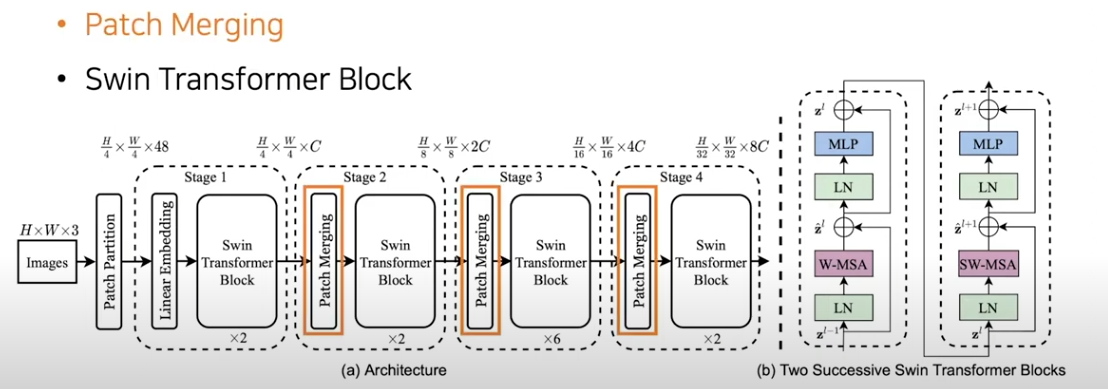

마지막 Patch Merging입니다. Stage2부터 Patch Merging이 진행된다고 했었죠. 아래 그림처럼 패치 수를 줄이는 과정입니다.

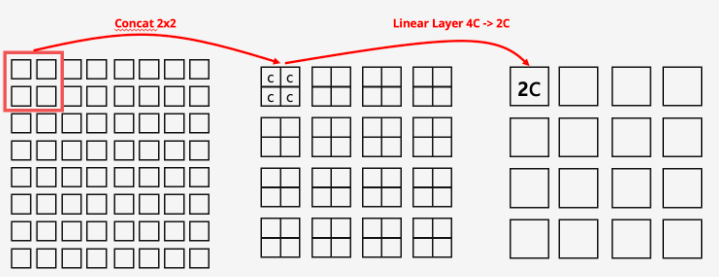

실제 연산은 1차원으로 벡터로 진행됩니다

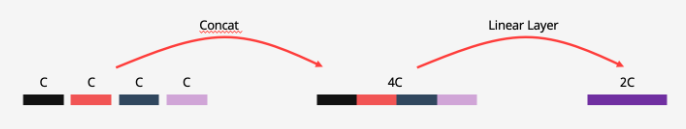

논문에서 왜 이렇게 reduction을 진행하는지 설명이 나와 있지 않지만, 외부 문서 설명에 따르면

1) 차원이 커지는 것을 방지하고,

 2) feature를 섞어주는 역할을 한다고 합니다.


In [7]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim):
        super(PatchMerging, self).__init__()

        self.input_resolution = input_resolution # 입력 이미지 해상도 (H, W)
        self.dim = dim # 각 패치의 채널 차원 (C)

        # 방금 얘기한 reduction, 1차원으로 진행됩니다.
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)

        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # 2x2 패치 병합
        # 입력 이미지를 네 개의 2x2 윈도우로 나눔
        x0 = x[:, 0::2, 0::2, :]  # 좌상단 패치
        x1 = x[:, 1::2, 0::2, :]  # 좌하단
        x2 = x[:, 0::2, 1::2, :]  # 우상단
        x3 = x[:, 1::2, 1::2, :]  # 우하단

        # 네 개의 패치를 하나의 패치로 병합
        x = torch.cat([x0, x1, x2, x3], -1)  # B, H/2, W/2, 4*C
        x = x.view(B, -1, 4 * C)

        x = self.norm(x)

        #  채널 차원을 4C에서 2C로 줄여서 패치 크기 조정
        x = self.reduction(x)  # B, H/2*W/2, 2*C

        return x

모델 설명은 이제 끝.

> # **실습**

이제 간단한 실습만 하면 과제는 끝납니다. 앞서 구현한 각 Component로 Swin Transformer를 구축해서 Cifar10 데이터셋으로 image classificaiton task를 수행해 봅시다.

> ## **데이터셋 불어오기**

cifar-10을 사용합니다

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# 전처리 함수
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 데이터셋 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100,shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **모델 정의하기**

- **TODO**를 채워주세요

In [9]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=96, depths=[2, 2], num_heads=[3, 6],
                 window_size=[4, 2], mlp_ratio=4., qkv_bias=True, dropout=0., attn_drop=0.):
        super(SwinTransformer, self).__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim

        # Patch Embedding: 입력 이미지를 작은 패치로 나누어 임베딩하는 Layer
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)

        self.pos_drop = nn.Dropout(p=dropout)

        # Swin Transformer Layer을 구성할 ModuleList 초기화
        self.layers = nn.ModuleList()
        self.patches_resolution = img_size // patch_size

        for i_layer in range(self.num_layers):
            # 각 Layer의 임베딩 차원 및 입력 해상도 계산
            dim = int(embed_dim * 2 ** i_layer)  # 각 Layer별로 임베딩 차원이 2배씩 증가

            input_resolution = (self.patches_resolution // (2 ** i_layer), self.patches_resolution // (2 ** i_layer))  # 입력 해상도

            # Swin Transformer Block 생성
            layer = nn.ModuleList()

            # _make_layer 메서드 사용하여 Layer 구성
            layer.append(self._make_layer(dim=dim,
                                          input_resolution=input_resolution,
                                          depth=depths[i_layer],
                                          num_heads=num_heads[i_layer],
                                          window_size=window_size[i_layer],
                                          mlp_ratio=mlp_ratio,
                                          qkv_bias=qkv_bias,
                                          dropout=dropout,
                                          attn_drop=attn_drop))

            # 마지막 Layer를 제외하고 PatchMerging 레이어 추가
            if i_layer < self.num_layers - 1:
                layer.append(PatchMerging(input_resolution, dim=dim))

            self.layers.append(layer)

        self.norm = nn.LayerNorm(int(embed_dim * 2 ** (self.num_layers - 1)))
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(int(embed_dim * 2 ** (self.num_layers - 1)), num_classes)

    # Swin Transformer Block Layer를 생성하는 함수
    def _make_layer(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4.,
                    qkv_bias=True, dropout=0., attn_drop=0.):

        layers = []
        for i in range(depth):
            shift_size = 0 if (i % 2 == 0) else window_size // 2
            layer = SwinTransformerBlock(dim=dim,
                                         input_resolution=input_resolution,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         shift_size=shift_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias,
                                         dropout=dropout,
                                         attn_drop=attn_drop)
            layers.append(layer)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer[0](x)  # SwinTransformerBlock
            if len(layer) > 1:
                x = layer[1](x)  # PatchMerging

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x


모델 선언

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTransformer(window_size=[4, 2]).to(device)

## **학습**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train

In [12]:
def train(epoch):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader): # train
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)

        # Loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward()

        # Weight update
        optimizer.step()

        # Train Loss
        running_loss += loss.item()

        # Prediction
        _, predicted = outputs.max(1)

        # Correct Predictions
        correct += predicted.eq(targets).sum().item()

        # Update samples
        total += targets.size(0)

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} [{batch_idx}/{len(trainloader)}] '
                  f'Loss: {running_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.3f}% ({correct}/{total})')

Test

In [13]:
def test(epoch):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader): # test
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward
            outputs = model(inputs)

            # Loss
            loss = criterion(outputs, targets)

            # Test Loss
            test_loss += loss.item()

            # Prediction
            _, predicted = outputs.max(1)

            # Correct Predictions
            correct += predicted.eq(targets).sum().item()

            # Update samples
            total += targets.size(0)

    print(f'Test Epoch {epoch} Loss: {test_loss/len(testloader):.3f} | '
          f'Acc: {100.*correct/total:.3f}% ({correct}/{total})')

Train Loop

In [14]:
for epoch in range(3):  # 돌아가는 것만 확인합시다
    train(epoch)
    test(epoch)

Epoch 0 [0/391] Loss: 2.356 | Acc: 7.031% (9/128)
Epoch 0 [100/391] Loss: 2.011 | Acc: 25.124% (3248/12928)
Epoch 0 [200/391] Loss: 1.907 | Acc: 29.108% (7489/25728)
Epoch 0 [300/391] Loss: 1.834 | Acc: 31.790% (12248/38528)
Test Epoch 0 Loss: 1.601 | Acc: 40.280% (4028/10000)
Epoch 1 [0/391] Loss: 1.744 | Acc: 29.688% (38/128)
Epoch 1 [100/391] Loss: 1.554 | Acc: 42.930% (5550/12928)
Epoch 1 [200/391] Loss: 1.547 | Acc: 43.377% (11160/25728)
Epoch 1 [300/391] Loss: 1.535 | Acc: 44.002% (16953/38528)
Test Epoch 1 Loss: 1.449 | Acc: 47.610% (4761/10000)
Epoch 2 [0/391] Loss: 1.518 | Acc: 46.875% (60/128)
Epoch 2 [100/391] Loss: 1.431 | Acc: 48.422% (6260/12928)
Epoch 2 [200/391] Loss: 1.422 | Acc: 48.492% (12476/25728)
Epoch 2 [300/391] Loss: 1.409 | Acc: 49.047% (18897/38528)
Test Epoch 2 Loss: 1.342 | Acc: 51.160% (5116/10000)


> # **제출**

- 맨 위 과제 제출란에 학습 성공한 스크린샷을 붙여넣고
- Week_07에 해당 파일을 올려주세요
- 수고 많으셨습니다~